In [1]:
from gensim import corpora, models, similarities
import numpy as np
from scipy import io
from sklearn import manifold

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict
rng = np.random.RandomState(1234)

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
###print mnist_x.shape

Using gpu device 0: GRID K520


In [2]:

import csv
import numpy as np
import prepre
####from nltk.stem import PorterStemmer
from gensim import corpora, models, similarities



file_name ='hey.csv'
file_name ='qqq2_pesdo.csv'
aaa=[]
yyy1=[]
yyy2=[]

###lmtzr = PorterStemmer()
### read data from hey.csv
with open(file_name, 'r') as f:
    reader = csv.reader(f)
    ###header = next(reader)
    for row in reader:
        ###aaa.append(row[0])
        yyy1.append(row[0])
        yyy2.append(row[1])

#######################
### exclude the docuement of no abstract 
#####################
texts=[]
'''
for kkk in range(len(aaa)):
    if(len(aaa[kkk]) ==0):
        print "error"
    texts.append(aaa[kkk])
texts = prepre.preprocess_documents(texts)
for document in texts:
	map(lmtzr.stem,document)
    
## make corpus
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=4, no_above=0.1)
dictionary.save('deerwester2.dict')
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('deerwester2.mm', corpus) 
'''

'\nfor kkk in range(len(aaa)):\n    if(len(aaa[kkk]) ==0):\n        print "error"\n    texts.append(aaa[kkk])\ntexts = prepre.preprocess_documents(texts)\nfor document in texts:\n\tmap(lmtzr.stem,document)\n    \n## make corpus\ndictionary = corpora.Dictionary(texts)\ndictionary.filter_extremes(no_below=4, no_above=0.1)\ndictionary.save(\'deerwester2.dict\')\ncorpus = [dictionary.doc2bow(text) for text in texts]\ncorpora.MmCorpus.serialize(\'deerwester2.mm\', corpus) \n'

In [3]:
corpus = corpora.MmCorpus('deerwester3.mm')
dictionary = corpora.Dictionary.load('deerwester3.dict')

corpus_sci = io.mmread('deerwester3.mm')
dictionary = corpora.Dictionary.load('deerwester3.dict')
train_X = corpus_sci.toarray().astype('float32')
print train_X.shape
####np.mean(np.sum(ee*np.array([[0,1,1],[0,0,1]]),axis=1))

yyy4=[]
for  tempp in yyy1:
    temp = tempp.split(", ")
    for i in range(len(temp)):
        temp[i] = temp[i].strip("[")
        temp[i] =temp[i].strip("]")

    yyy4.append(map(int,temp))

(46467, 21771)


In [4]:
print yyy4[0:10]
yyy = np.array(yyy4)
train_y=np.zeros([len(yyy),153])
for i,j in enumerate(yyy):
    for k in j:
        if(k<=151):
            train_y[i][k]=1/(1.0*len(j))
print train_X.shape
print train_y.shape
train_y = train_y.astype('float32')

####train_X, train_y = shuffle(train_X,train_y)
train__X = train_X[:40000]
train__y = train_y[:40000]
test_X = train_X[-1500:]
test_y = train_y[-1500:]

print test_X.shape
print test_y.shape

[[76], [76], [101, 88], [101, 88], [101, 88], [101, 88], [101, 88], [76, 78, 100], [76, 78, 100], [76, 78, 100]]
(46467, 21771)
(46467, 153)
(1500, 21771)
(1500, 153)


In [ ]:
###train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [5]:
 #SGD
def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates
  

#Multi Layer Perceptron
class Layer:
    def __init__(self, in_dim, out_dim, function):
        self.W = theano.shared(rng.uniform(low=-np.sqrt(6. / (in_dim + out_dim)),high =np.sqrt(6. / (in_dim + out_dim)),size =(in_dim,out_dim)).astype('float32'), name = 'W')
        self.b = theano.shared(np.zeros(out_dim).astype('float32'), name = 'bias')
        self.params = [ self.W, self.b]
        
        self.W1 = theano.shared(0*rng.uniform(low=-np.sqrt(6. / (in_dim + out_dim)),high =np.sqrt(6. / (in_dim + out_dim)),size =(in_dim,out_dim)).astype('float32'), name = 'W')
        self.b1 = theano.shared(np.zeros(out_dim).astype('float32'), name = 'bias')
        self.momentums = [ self.W1, self.b1]       
             
        self.function = function
        self.h = None
        self.in_dim = in_dim
        self.out_dim =out_dim

    def fprop(self, x):
        h=self.function(theano.tensor.dot(x,self.W)+self.b)
        self.h = h
        return h
    
    def set_pretraining(self):
        ae = Autoencoder(self.in_dim,self.out_dim,self.W,self.function)
        ###noise = T.matrix('noise')
        ###noise =rng.binomial(size=train_X[start:end].shape, n=1, p=1-corruption_level)
        ##start = i*batch_size
        ##end = (i+1)*batch_size
        self.params[0] =ae.params[0]
        x  = T.matrix('X')
        noise = T.matrix('noise')
        ###noise =rng.binomial(size=x.shape, n=1, p=1-corruption_level)
        cost,reconst_x = ae.reconst_error(x,noise)
        params  = ae.params
        gparams = T.grad(cost, params)
        updates = sgd(params,gparams)
        self.pretraining = theano.function([x,noise], [cost,reconst_x], updates=updates, allow_input_downcast=True)
        hidden = ae.encode(x)
        self.encode_function = theano.function([x], hidden, allow_input_downcast=True)


def sgd(params,gparams,lr=0.1):
    updates = OrderedDict()
    for param, gparam in zip(params, gparams):
        updates[param] = param - lr * gparam
    return updates

def sgd2(params,momentums,gparams,lr=0.1):
    updates = OrderedDict()
    for param, momentum,gparam in zip(params,momentums,gparams):
        updates[momentum] = -lr*gparam + 0.4*momentum
        updates[param] = momentum + param
    return updates

In [6]:
pred_cand =[]


layers = [Layer(21771,1500,T.nnet.sigmoid),Layer(1500,153, T.nnet.softmax)]
#Fine-tuning
x, t = T.fmatrix("x"), T.fmatrix("t")
llr =T.fscalar("llr")
params = []
momentums = []
for i, layer in enumerate(layers):
    params += layer.params
    momentums += layer.momentums
    if i == 0:
        layer_out = layer.fprop(x)
    else:
        layer_out = layer.fprop(layer_out)

y = layers[-1].h
###cost = - T.mean((T.log(y))[T.arange(y.shape[0]), t])
cost = -T.mean(T.sum(T.log(y)*t,axis=1))
gparams = T.grad(cost, params)
updates = sgd2(params,momentums,gparams,llr)

####updates2 =sgd(params,gparams,lr=0.01)

train = theano.function([x,t,llr], cost, updates=updates)

valid  = theano.function([x,t],[cost, T.argmax(y, axis=1)])
test3  = theano.function([x],y)

In [13]:
batch_size = 50
answer =[]
nbatches = train__X.shape[0]//batch_size
for epoch in range(2):
    train__X, train__y = shuffle(train__X,train__y)
    if epoch<15:
        for i in range(nbatches):
            start = i*batch_size
            end = (i+1)*batch_size
            train(train__X[start:end],train__y[start:end],0.01)   
    else:
        for i in range(nbatches):
            start = i*batch_size
            end = (i+1)*batch_size
            train(train__X[start:end],train__y[start:end],0.01)               
    valid_cost ,pre_y = valid(test_X,test_y)
    ####valid_cost2 ,pre_y = valid(train__X,train__y)
    print "valid1",valid_cost
    ####print "valid2",valid_cost2
    pred_y = test3(test_X)
    pred_cand.append(pred_y)

for i,j in enumerate(pred_cand):
    if i==0:
        pred_cand_cand = j
    else:
        pred_cand_cand = pred_cand_cand + j

pred_cand_cand = pred_cand_cand/len(pred_cand_cand)*1.0
pred_y = np.argmax(pred_cand_cand, axis=1)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
####print len(answer)
###print pred_cand

valid1 1.47571706772
valid1 1.47814929485


In [51]:
pesdo_test =np.argmax(test_y, axis=1)

###pred_cand_man = [[j,i] for for i in enumerate(pred_cand_cand)]

pesdo_test_2 =[[list(i).index(sorted(i)[-3]),list(i).index(sorted(i)[-2]),list(i).index(sorted(i)[-1])] for i in pred_cand_cand]

pred_cand_cand
for j,i in enumerate(range(len(pesdo_test))):
    print (pesdo_test_2[j],yyy4[-1500+i],i)
    
count =0
    
        
print count
print classification_report(pred_y,pesdo_test)

([22, 9, 40], [22], 0)
([9, 0, 22], [22], 1)
([9, 31, 40], [22], 2)
([9, 56, 0], [22], 3)
([76, 88, 81], [81], 4)
([75, 88, 81], [81], 5)
([101, 97, 88], [97], 6)
([94, 81, 97], [97], 7)
([111, 94, 97], [97], 8)
([94, 88, 97], [97], 9)
([81, 88, 97], [97], 10)
([105, 94, 97], [97], 11)
([88, 81, 97], [97], 12)
([88, 76, 101], [76, 152, 101, 88], 13)
([88, 76, 101], [76, 152, 101, 88], 14)
([105, 76, 97], [76, 152, 101, 88], 15)
([101, 76, 88], [76, 152, 101, 88], 16)
([76, 101, 88], [76, 152, 101, 88], 17)
([76, 75, 88], [76, 152, 101, 88], 18)
([101, 88, 76], [76, 152, 101, 88], 19)
([97, 76, 88], [76, 152, 101, 88], 20)
([97, 101, 76], [76, 97], 21)
([97, 101, 76], [76, 97], 22)
([101, 81, 97], [81, 102], 23)
([105, 97, 88], [97, 88], 24)
([46, 11, 6], [11, 55], 25)
([81, 88, 75], [75], 26)
([130, 88, 81], [81], 27)
([105, 101, 97], [97], 28)
([96, 111, 97], [97], 29)
([94, 97, 88], [97], 30)
([76, 88, 97], [97], 31)
([101, 88, 97], [97], 32)
([94, 81, 97], [97], 33)
([105, 88, 97], 

In [144]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

print np.array(train_X).shape
print len(corpus_tfidf)

kkkk = len(dictionary.token2id)

'''
### to see the keys
print dictionary.token2id
'''

print corpus_tfidf
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=50)
corpus_lsi = lsi[corpus_tfidf]
heyhey = np.array(list(corpus_lsi))
print heyhey[2]


(7975, 9112)
7975
[[  0.00000000e+00   1.04093298e-01]
 [  1.00000000e+00   6.70608605e-02]
 [  2.00000000e+00  -7.24494307e-02]
 [  3.00000000e+00  -1.02386853e-01]
 [  4.00000000e+00   1.44371744e-02]
 [  5.00000000e+00   2.92372230e-02]
 [  6.00000000e+00  -1.35353239e-02]
 [  7.00000000e+00   6.79250084e-03]
 [  8.00000000e+00   2.94272604e-02]
 [  9.00000000e+00   1.68625074e-03]
 [  1.00000000e+01  -4.31983089e-03]
 [  1.10000000e+01   3.79730984e-02]
 [  1.20000000e+01   1.80766920e-02]
 [  1.30000000e+01  -1.33383111e-02]
 [  1.40000000e+01   2.21274671e-02]
 [  1.50000000e+01   1.41529030e-02]
 [  1.60000000e+01  -5.58772243e-02]
 [  1.70000000e+01   1.45747583e-02]
 [  1.80000000e+01   1.23296404e-02]
 [  1.90000000e+01   4.13146543e-03]
 [  2.00000000e+01  -1.37279244e-02]
 [  2.10000000e+01  -2.35082899e-02]
 [  2.20000000e+01  -7.78405604e-03]
 [  2.30000000e+01   5.52737100e-02]
 [  2.40000000e+01  -4.38954424e-02]
 [  2.50000000e+01  -1.70873649e-02]
 [  2.60000000e+01  

In [151]:
heyhey = np.array(list(corpus_lsi))
heyhey2 = [i[:,1] for i in heyhey]

/Library/Python/2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


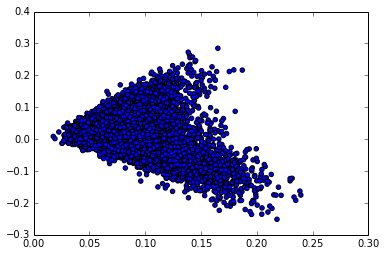

In [142]:
hey1 =[]
hey2 =[]
for i in heyhey:
    if(i!=[]):
        hey1.append(i[0][1])
        hey2.append(i[1][1])  


%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(hey1,hey2)
plt.show()  

In [16]:
hey1 =[]
hey2 =[]
def make_color(i):
    if(i=='[1]'):
        return 'b'
    elif(i=='[2]'):
        return 'g'
    elif(i=='[3]'):
        return 'r'
    elif(i=='[4]'):
        return 'c'
    else:
        return 'm'
print yyy2[0:10]
yyy3 = map(make_color,yyy2)
print yyy3[0:10]

yyy4=[]
for  tempp in yyy1:
    temp = tempp.split(", ")
    for i in range(len(temp)):
        temp[i] = temp[i].strip("[")
        temp[i] =temp[i].strip("]")

    yyy4.append(map(int,temp))

yyy5 = [(i[0]*1.0)/159.0 for i in yyy4]
for i in np.array(list(corpus_lsi)):
    hey1.append(i[0][1])
    hey2.append(i[1][1])   
    
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(hey1,hey2,c =yyy5)
plt.savefig('pesdo3.png')
plt.show()

['[2]', '[2]', '[3]', '[3]', '[3]', '[3]', '[3]', '[2]', '[2]', '[2]']
['g', 'g', 'r', 'r', 'r', 'r', 'r', 'g', 'g', 'g']


NameError: name 'corpus_lsi' is not defined

In [34]:
corpus_sci = io.mmread('deerwester2.mm')
dictionary = corpora.Dictionary.load('deerwester2.dict')
train_X = corpus_sci.toarray()
print train_X

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


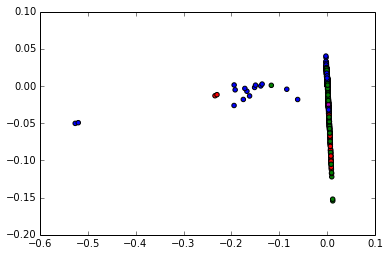

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
X = np.array([[1,2,3],[2,3,4],[5,6,7],[8,9,10]])
y = manifold.locally_linear_embedding(train_X[0:3000],n_neighbors=4, n_components=2)

hey1 =[]
hey2 =[]
for i in y[0]:
    ####if(i!=[]):
        hey1.append(i[0])
        hey2.append(i[1])  
plt.scatter(hey1,hey2,c=yyy3[0:3000])
plt.show()      

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


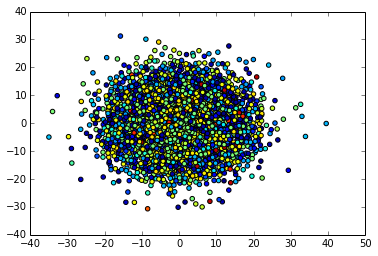

In [97]:
###y = manifold.Isomap( n_components=2).fit_transform(train_X[0:300])
mds = manifold.MDS(n_components=2, max_iter=100, n_init=1).fit_transform(train_X[0:5000])

hey1 =[]
hey2 =[]
for i in mds:
    if(i!=[]):
        hey1.append(i[0])
        hey2.append(i[1])  
plt.scatter(hey1,hey2,c=yyy5[0:5000])
plt.show() 

7975


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


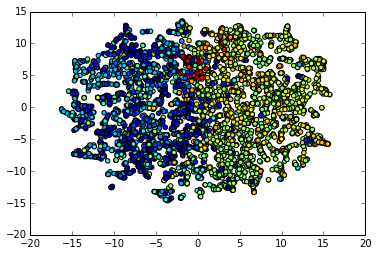

In [161]:


print len(heyhey2)
sne = manifold.TSNE(n_components=2, init='pca', perplexity=8.0,random_state=0).fit_transform(heyhey2[0:5000])

hey1 =[]
hey2 =[]
for i in sne:
    if(i!=[]):
        hey1.append(i[0])
        hey2.append(i[1])  
plt.scatter(hey1,hey2,c=yyy5[0:5000])
plt.savefig("pesdo4.png")
plt.show() 

In [15]:
print y

[[  8.39275817e-02  -9.47141654e-02]
 [ -3.09918779e-02   1.13605021e-01]
 [ -9.22918350e-02   3.23458464e-01]
 [ -3.23742889e-02   1.73234769e-01]
 [ -5.49481928e-02   1.58176727e-01]
 [ -4.72927821e-03   6.51732441e-02]
 [  4.58449320e-02  -2.67377816e-02]
 [ -2.75856792e-01   7.60597815e-01]
 [  7.74460471e-02  -8.32201933e-02]
 [  7.65376779e-02  -8.16068917e-02]
 [ -9.57609645e-02   2.34921300e-01]
 [ -3.83159425e-02   1.27192880e-01]
 [ -3.09918779e-02   1.13605021e-01]
 [ -6.43463877e-02   1.75760654e-01]
 [  1.56446770e-02   2.79264780e-02]
 [ -8.37939231e-02   2.12316251e-01]
 [ -5.01057237e-01   1.27200579e+00]
 [ -7.08929397e-03   6.95063860e-02]
 [ -5.51554731e-03   6.66164603e-02]
 [ -3.13812137e-01   6.59975913e-01]
 [ -1.32222583e-01   3.04293735e-01]
 [ -1.14986169e-01   2.71407545e-01]
 [ -1.00469851e-01   2.43838690e-01]
 [  8.06082304e-02  -7.12225731e-02]
 [  1.20305057e-01  -1.58668743e-01]
 [  4.91124252e-02  -3.26121451e-02]
 [ -6.60768459e-02   1.79004210e-01]
 